<a href="https://colab.research.google.com/github/masa512/ece558/blob/main/assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem 5.1

In [1]:
from skimage.data import shepp_logan_phantom 
from skimage.transform import resize,radon
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Generate Image
N = 32 # pick whatever size
X = resize(shepp_logan_phantom(), (N,N))

In [3]:
def projmtx(N,thetas):
  #Initialize bj's as columns
  B = np.diag(np.ones(N*N))
  M = thetas.shape[0]
  # Radon returns t by ang
  sinos = np.array([radon(B[:,j].reshape(N,N),theta=thetas,circle=False).reshape((-1)) for j in range(N*N)]).T
  return sinos

In [4]:
def art(y,x_0,T):
  x = x_0
  for t in range(2):
    # Lets do the forloop over j and l
    dx = np.linalg.inv(T.T@T)@(T.T @ (y-T@x))
    x = x + dx
  return x

## PART a

/usr/local/lib/python3.8/dist-packages/skimage/transform/radon_transform.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  R = np.array([[cos_a, sin_a, -center * (cos_a + sin_a - 1)],


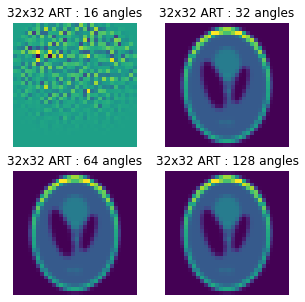

In [5]:
# 
f,axes = plt.subplots(2,2,figsize=(5,5))
axes = np.ravel(axes)

N_thetas = [16,32,64,128]
for i,Nt in enumerate(N_thetas):

  thetas = np.linspace(0., 180., Nt, endpoint=False).reshape((-1,1))
  x = X.reshape((-1,1))
  T = projmtx(N,thetas)
  y = T @ x

  # ART reconstruction
  x_0 = np.ones_like(x)
  xr = art(y,x_0,T)

  # Plot
  axes[i].imshow(xr.reshape(N,N))
  axes[i].set_title(f'{N}x{N} ART : {Nt} angles')
  axes[i].axis('off')


The reconstruction is fine as long as $N_{\theta} <= N$ where $N$ is one dimension of square image

## ART with positivity constraint

In [6]:
def art_plus(y,x_0,T):
  x = x_0
  for t in range(2):
    # Lets do the forloop over j and l
    dx = np.linalg.inv(T.T@T)@(T.T @ (y-T@x))
    x = x + dx
    x[x<0] = 0 # The positivity constraint!!
  return x


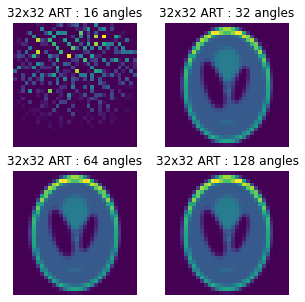

In [7]:
# 
f,axes = plt.subplots(2,2,figsize=(5,5))
axes = np.ravel(axes)

N_thetas = [16,32,64,128]
for i,Nt in enumerate(N_thetas):

  thetas = np.linspace(0., 180., Nt, endpoint=False).reshape((-1,1))
  x = X.reshape((-1,1))
  T = projmtx(N,thetas)
  y = T @ x

  # ART reconstruction
  x_0 = np.ones_like(x)
  xr = art_plus(y,x_0,T)

  # Plot
  axes[i].imshow(xr.reshape(N,N))
  axes[i].set_title(f'{N}x{N} ART : {Nt} angles')
  axes[i].axis('off')


#Problem 5.4

In [8]:
# Case 1 : Limited Angle
Nt = 32
thetas1 = np.linspace(0., 90., Nt, endpoint=False).reshape((-1,1))
T_LA = projmtx(N,thetas1)

# Case 2 : Sparse Data
Nt = 8
thetas2 = np.linspace(0., 180., Nt, endpoint=False).reshape((-1,1))
T_SD = projmtx(N,thetas2)

# Case 3 : Complete Data
Nt = 32
thetas3 = np.linspace(0., 180., Nt, endpoint=False).reshape((-1,1))
T_CD = projmtx(N,thetas3)

Text(0.5, 1.0, 'Complete Angle')

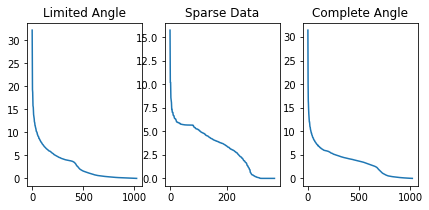

In [33]:
# SVD for case 1
U1,S1,V1T = np.linalg.svd(T_LA)

# SVD for case 2
U2,S2,V2T = np.linalg.svd(T_SD)

# SVD for case 3
U3,S3,V3T = np.linalg.svd(T_CD)

# Plot the singular values
f,axes = plt.subplots(1,3,figsize=(7,3))
axes[0].plot(S1)
axes[0].set_title('Limited Angle')
axes[1].plot(S2)
axes[1].set_title('Sparse Data')
axes[2].plot(S3)
axes[2].set_title('Complete Angle')

In [10]:
def ramp_filter(L):
  # lets assume N is even
  v = np.arange(L)
  v = abs(v - L//2)
  return np.fft.ifftshift(v)


def fbp(y,T,thetas):

  # Reshape y into t vs theta
  Y = y.reshape(-1,thetas.shape[0])

  # Take fft along axis 0
  fY = np.fft.fft(Y,axis=0)

  # Multiply by the ramp filter
  fR = ramp_filter(Y.shape[0]).reshape(-1,1)
  fYR = fY*fR
  

  # Take inversefft and apply T.T
  filtered_Y = np.fft.ifft(fYR,axis=0)
  Xfbp = (T.T)@(filtered_Y.reshape(-1,1))
  return Xfbp

Text(0.5, 1.0, 'FBP: Complete Data')

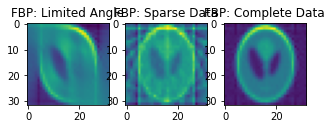

In [11]:
# Forward Projection for three cases
x = X.reshape((-1,1))
y1 = T_LA @ x
y2 = T_SD @ x 
y3 = T_CD @ x

# Perform filtered backprojection
x1 = np.real(fbp(y1,T_LA,thetas1))
x2 = np.real(fbp(y2,T_SD,thetas2))
x3 = np.real(fbp(y3,T_CD,thetas3))

# Reshape and plot
f,axes = plt.subplots(1,3,figsize=(5,5))
X1 = x1.reshape(N,N)
axes[0].imshow(X1)
axes[0].set_title('FBP: Limited Angle')
X2 = x2.reshape(N,N)
axes[1].imshow(X2)
axes[1].set_title('FBP: Sparse Data')
X3 = x3.reshape(N,N)
axes[2].imshow(X3)
axes[2].set_title('FBP: Complete Data')

Text(0.5, 1.0, 'PINV: Complete Data')

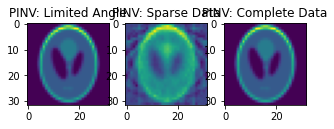

In [12]:
# Use the pseudo-inverse to solve instead
T_LA_inv = np.linalg.pinv(T_LA)
T_SD_inv = np.linalg.pinv(T_SD)
T_CD_inv = np.linalg.pinv(T_CD)

# Apply and plot
x1_pseudo = T_LA_inv @ y1
x2_pseudo = T_SD_inv @ y2
x3_pseudo = T_CD_inv @ y3

# Plot
# Reshape and plot
f,axes = plt.subplots(1,3,figsize=(5,5))
X1_pseudo = x1_pseudo.reshape(N,N)
axes[0].imshow(X1_pseudo)
axes[0].set_title('PINV: Limited Angle')

X2_pseudo = x2_pseudo.reshape(N,N)
axes[1].imshow(X2_pseudo)
axes[1].set_title('PINV: Sparse Data')

X3_pseudo = x3_pseudo.reshape(N,N)
axes[2].imshow(X3_pseudo)
axes[2].set_title('PINV: Complete Data')


We see almost perfect reconstruction for Limited angle and complete data, but we don't quite see any difference for Sparse Data. Resolution is hard to recover just using pseudoinverse

# Problem 5.5

In [13]:
# Add sigmal = 0.1 gaussian noise to y1, y2, y3
sigma = 0.1
y1_noisy = y1 + np.random.normal(0,sigma,size = y1.shape)
y2_noisy = y2 + np.random.normal(0,sigma,size = y2.shape)
y3_noisy = y3 + np.random.normal(0,sigma,size = y3.shape)


## Plot the SVD Ratio

In [14]:
def plot_SVD(T,y,title = ''):
  # Plotting the first part
  U,S,Vt = np.linalg.svd(T)
  inner = abs(np.asarray([np.dot(U.T[i,:],y) for i in range(U.shape[0])]).reshape(-1,))

  f,axes = plt.subplots(3,1,figsize=(5,5))
  axes[0].plot(inner)
  axes[0].set_title('Inner Product')

  axes[1].plot(S)
  axes[1].set_title('Singular Values')


  # Trucate the inner products upto Rank
  axes[2].plot((inner[:S.shape[0]]/(S+1e-8)))
  axes[2].set_title('Ratio')

  plt.suptitle(title)

  
  


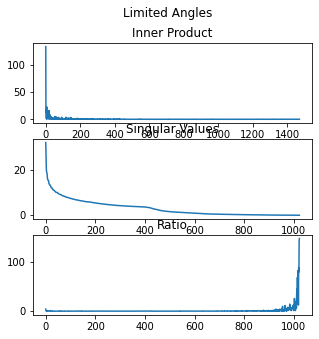

In [15]:
plot_SVD(T_LA,y1_noisy,'Limited Angles')

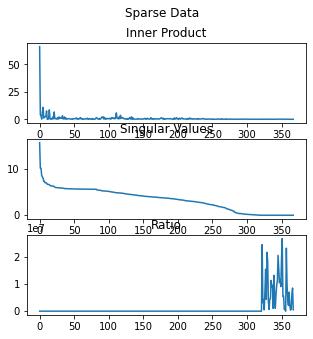

In [16]:
plot_SVD(T_SD,y2_noisy,'Sparse Data')

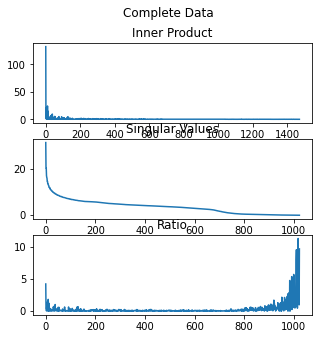

In [17]:
plot_SVD(T_CD,y3_noisy,'Complete Data')

## Plot images of V

In [34]:
def plot_SVD2(T,y,title = ''):
  U,S,Vt = np.linalg.svd(T)
  # Part 2 : Image plot
  f,axes = plt.subplots(2,2,figsize=(4,4))
  axes = axes.ravel()
  idxs = [1,50,100,150]
  
  for i, idx in enumerate(idxs):
    axes[i].imshow(Vt.T[:,idx].reshape(N,N))
    axes[i].set_title('idx = ' + str(idx))
  plt.suptitle(title)

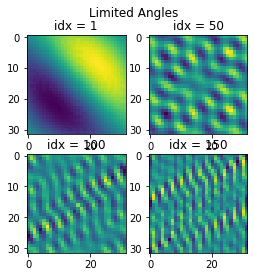

In [35]:
plot_SVD2(T_LA,y1_noisy,'Limited Angles')

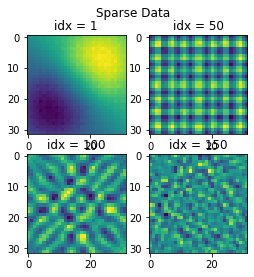

In [36]:
plot_SVD2(T_SD,y2_noisy,'Sparse Data')

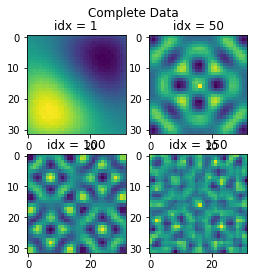

In [37]:
plot_SVD2(T_CD,y3_noisy,'Complete Data')

## Print Condition Number|

In [22]:
def CN_print(T,title):
  _,S,_ = np.linalg.svd(T)
  print('Condition Number for '+title+'= '+str(max(S)/min(S)))

# LA
CN_print(T_LA,'Limited Angle')

# SD
CN_print(T_SD,'Sparse Data')

# LA
CN_print(T_CD,'Complete Data')

Condition Number for Limited Angle= 69452.29163504441
Condition Number for Sparse Data= 6.062864708101626e+16
Condition Number for Complete Data= 3017.5452911470134


All Three reconstructions are "ILL-CONDITIONED" since the condition numbers FAR exceed 1 due to the noise divided by the singular values for PINV process

## Regularization of the problem

In [23]:
def TSVD(T,alpha):
  """
  Creates lower rank SVD by filtering the singular values by alpha

  Input
  T (N,M): Transformation matrix
  alpha (Scalar): The threshold for singular values
  """

  U,S,Vt = np.linalg.svd(T)

  # Filter out the singular values
  S_filt = S[S>alpha]
  N = S_filt.shape[0]
  U_filt = U[:,:N]
  Vt_filt = Vt[:N,:]

  # Rebuild T

  T_rebuild = U_filt @ np.diag(S_filt) @ Vt_filt
  return T_rebuild


(0.0, 1.0, 0.0, 1.0)

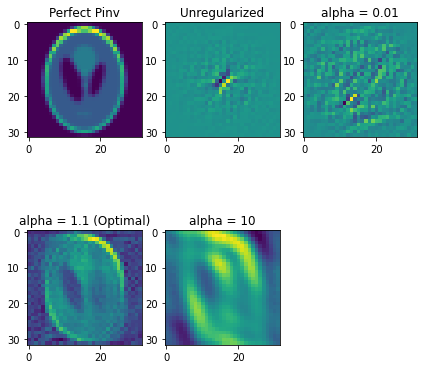

In [27]:
# Case 1 : Limitted angle
f,axes = plt.subplots(2,3,figsize=(7,7))
axes = np.ravel(axes)

axes[0].imshow(X1_pseudo)
axes[0].set_title('Perfect Pinv')

X_unreg = (np.linalg.pinv(T_LA)@y1_noisy).reshape(N,N)
axes[1].imshow(X_unreg)
axes[1].set_title('Unregularized')

# Low 
alpha = 0.01
T_LA_reg = TSVD(T_LA,alpha)
X_reg = (np.linalg.pinv(T_LA_reg)@y1_noisy).reshape(N,N)
axes[2].imshow(X_reg)
axes[2].set_title(f'alpha = {alpha}')

# Optimal
alpha = 1.1
T_LA_reg = TSVD(T_LA,alpha)
X_reg = (np.linalg.pinv(T_LA_reg)@y1_noisy).reshape(N,N)
axes[3].imshow(X_reg)
axes[3].set_title(f'alpha = {alpha} (Optimal)')

# Too high
alpha = 10
T_LA_reg = TSVD(T_LA,alpha)
X_reg = (np.linalg.pinv(T_LA_reg)@y1_noisy).reshape(N,N)
axes[4].imshow(X_reg)
axes[4].set_title(f'alpha = {alpha}')

plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

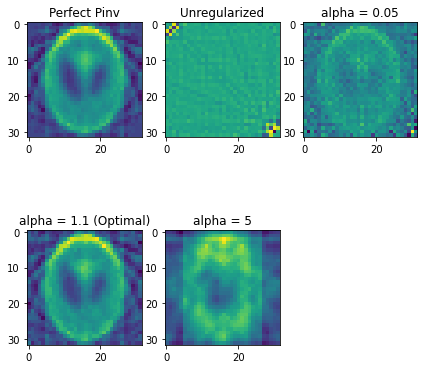

In [28]:
# Case 2 : Sparse Data
f,axes = plt.subplots(2,3,figsize=(7,7))
axes = np.ravel(axes)

axes[0].imshow(X2_pseudo)
axes[0].set_title('Perfect Pinv')

X_unreg = (np.linalg.pinv(T_SD)@y2_noisy).reshape(N,N)
axes[1].imshow(X_unreg)
axes[1].set_title('Unregularized')

# Low 
alpha = 0.05
T_SD_reg = TSVD(T_SD,alpha)
X_reg = (np.linalg.pinv(T_SD_reg)@y2_noisy).reshape(N,N)
axes[2].imshow(X_reg)
axes[2].set_title(f'alpha = {alpha}')

# Optimal
alpha = 1.1
T_SD_reg = TSVD(T_SD,alpha)
X_reg = (np.linalg.pinv(T_SD_reg)@y2_noisy).reshape(N,N)
axes[3].imshow(X_reg)
axes[3].set_title(f'alpha = {alpha} (Optimal)')

# Too high
alpha = 5
T_SD_reg = TSVD(T_SD,alpha)
X_reg = (np.linalg.pinv(T_SD_reg)@y2_noisy).reshape(N,N)
axes[4].imshow(X_reg)
axes[4].set_title(f'alpha = {alpha}')

plt.axis('off')


(0.0, 1.0, 0.0, 1.0)

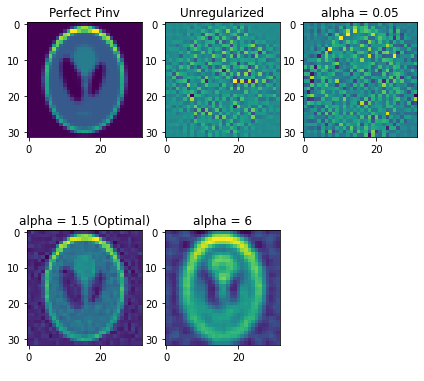

In [29]:
# Case 3 : Complete Data
f,axes = plt.subplots(2,3,figsize=(7,7))
axes = np.ravel(axes)

axes[0].imshow(X3_pseudo)
axes[0].set_title('Perfect Pinv')

X_unreg = (np.linalg.pinv(T_CD)@y3_noisy).reshape(N,N)
axes[1].imshow(X_unreg)
axes[1].set_title('Unregularized')

# Low 
alpha = 0.05
T_CD_reg = TSVD(T_CD,alpha)
X_reg = (np.linalg.pinv(T_CD_reg)@y3_noisy).reshape(N,N)
axes[2].imshow(X_reg)
axes[2].set_title(f'alpha = {alpha}')

# Optimal
alpha = 1.5
T_CD_reg = TSVD(T_CD,alpha)
X_reg = (np.linalg.pinv(T_CD_reg)@y3_noisy).reshape(N,N)
axes[3].imshow(X_reg)
axes[3].set_title(f'alpha = {alpha} (Optimal)')

# Too high
alpha = 6
T_CD_reg = TSVD(T_CD,alpha)
X_reg = (np.linalg.pinv(T_CD_reg)@y3_noisy).reshape(N,N)
axes[4].imshow(X_reg)
axes[4].set_title(f'alpha = {alpha}')

plt.axis('off')


The optimal value of $\alpha$ is roughly around 1.

If the alpha is too low (too tolerant) you end up having too much explosions from noise. On the other hand, if you let alpha be too big (too strict) you lose the actual structure of the object.